# Solving advection equation using ELM-ODE and SWIM-ODE for different values of flow velocities
In this script, we see how the SWIM-ODE and ELM-ODE performs for different values of flow velocities.

In [1]:
# Imports
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BoundaryCompliantAnsatz
from swimpde import AdvectionSolver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
np.random.seed(2)
import time

### Problem setup

In [2]:
# create equally spaced points in a square
n_points_1d = 400 
x_lim = [0, 2 * np.pi]

# coordinates of boundary points (excluding corners)
left = x_lim[0]
right = x_lim[1]
boundary_points = np.row_stack([left, right])

# initial condition
def u0(x):
    return np.sin(x)

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# boundary condition
boundary_condition = "periodic" #strict

# Analytical solution
def analytical_sol(x, t, beta):
    return np.sin(x - beta * t)

# Test data
t_eval = np.linspace(0, 1, 100) # time domain
x_space_test = np.linspace(x_lim[0], x_lim[-1], 256).reshape((-1, 1)) # space domain
xx_test, yy_test = np.meshgrid(x_space_test, t_eval)
X_test = np.hstack((xx_test.reshape(-1, 1), yy_test.reshape(-1, 1))) # Uniform test points


### Fit and evaluate SWIM-ODE and ELM-ODE for good hyper-parameters 

In [3]:
conv_coeffs = [1e-3, 1e-2, 1e-1, 1, 10, 40, 100, 500, 1000, 5000, 10000] # Values of convection coefficient
n_c = 400 # Number of data points for convection coefficient 100
seeds = [1, 2, 3]
experiments = []

n_IBF = 380
n_OBF = 14

# Parameter sampler for ELM: Sample weights from a normal distribution and biases uniformly from [-4, 4]
def sample_parameters_randomly(x, _, rng):
    weights = rng.normal(loc=0, scale=1, size=(x.shape[1], n_IBF))
    biases = rng.uniform(low=-4, high=4, size=(1, n_IBF)) # low=-np.pi, high=np.pi,  2 * np.pi
    idx0 = None
    idx1 = None
    return weights, biases, idx0, idx1

# Periodic basis functions
def periodic_outer_basis_sine(x_space, n_outer_basis=None, initial_condition=None):
    return np.column_stack([
        sine_cos(x_space * (i+1))
        for i in range(n_outer_basis//2)
        for sine_cos in [np.sin, np.cos]
    ])

for conv_coeff in conv_coeffs:
    # Ground truth for the selected convection coefficient
    u_true_test = analytical_sol(x_space_test, t_eval, conv_coeff).T

    # Loop over different seeds
    rmse_swim = np.ones((len(seeds), ))
    rmse_elm = np.ones((len(seeds), ))
    rel_err_swim = np.ones((len(seeds), ))
    rel_err_elm = np.ones((len(seeds), ))
    time_swim = np.ones((len(seeds), ))
    time_elm = np.ones((len(seeds), ))
    j = 0
    info = []
    for seed in seeds:
        ansatz_swim = BoundaryCompliantAnsatz(
                n_outer_basis=n_OBF,
                n_inner_basis=n_IBF,
                activation="tanh",
                random_state=seed,
                regularization_scale=1e-10,
                target_gen=periodic_outer_basis_sine,
            )
        ansatz_elm = BoundaryCompliantAnsatz(
                n_outer_basis=n_OBF,
                n_inner_basis=n_IBF,
                activation="tanh",
                random_state=seed,
                regularization_scale=1e-10,
                target_gen=periodic_outer_basis_sine,
                parameter_sampler = sample_parameters_randomly
        )
        
        # Collocation points in space
        x_space = np.linspace(x_lim[0], x_lim[1], n_c).reshape((-1, 1))

        # interior points
        x_space_inner = x_space[1:-1]
        interior_points = x_space_inner

        # Domain
        domain = Domain(
            interior_points=interior_points,
            boundary_points=boundary_points,
        )
        
        adv_solver_swim = AdvectionSolver(
            domain=domain, 
            ansatz=ansatz_swim,
            u0=u0,
            boundary_condition=boundary_condition,
            c=conv_coeff,
            forcing=forcing,
            regularization_scale=1e-10,
        )
        adv_solver_elm = AdvectionSolver(
            domain=domain, 
            ansatz=ansatz_elm,
            u0=u0,
            boundary_condition=boundary_condition,
            c=conv_coeff,
            forcing=forcing,
            regularization_scale=1e-10,
        )
        
        # Compute weights and biases of the SWIM network
        time_blocks = 1
        t_swim_start = time.time()
        sol_swim, solver_status_swim = adv_solver_swim.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10, svd_cutoff=1e-12);
        t_swim_stop = time.time()
        time_swim[j] = t_swim_stop - t_swim_start
        
        t_elm_start = time.time()
        sol_elm, solver_status_elm = adv_solver_elm.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10, svd_cutoff=1e-12);
        t_elm_stop = time.time()
        time_elm[j] = t_elm_stop - t_elm_start
        
        # Evaluate on test data
        u_elm_test = adv_solver_elm.evaluate(x_eval=x_space_test, t_eval = t_eval, solver_status=solver_status_elm).T
        u_swim_test = adv_solver_swim.evaluate(x_eval=x_space_test, t_eval = t_eval, solver_status=solver_status_swim).T #, solver_status=solver_status
                    
        # Compute metrics
        rmse_elm[j] = np.sqrt(mean_squared_error(u_true_test, u_elm_test))
        rmse_swim[j] = np.sqrt(mean_squared_error(u_true_test, u_swim_test))  # mean squared error
        rel_err_elm[j] = rmse_elm[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
        rel_err_swim[j] = rmse_swim[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
        j += 1

    info.append(np.mean(time_elm))
    info.append(np.mean(time_swim))
    info.append(np.mean(rmse_elm))
    info.append(np.std(rmse_elm))
    info.append(np.mean(rmse_swim))
    info.append(np.std(rmse_swim))
    info.append(np.mean(rel_err_elm))
    info.append(np.std(rel_err_elm))
    info.append(np.mean(rel_err_swim))
    info.append(np.std(rel_err_swim))

    print(info)
    experiments.append(info) 
        

[0.033757527669270836, 0.043172359466552734, 6.217344519192376e-10, 2.4616337261142887e-10, 4.376065445360843e-10, 1.3672746304091418e-10, 8.809876555990293e-10, 3.488095148368321e-10, 6.200813909468158e-10, 1.9374060219533226e-10]
[0.03362154960632324, 0.03935082753499349, 6.246828525178684e-10, 2.446835408742689e-10, 4.37025971573426e-10, 1.363557135024605e-10, 8.85165376400437e-10, 3.467125721219772e-10, 6.192586479128512e-10, 1.9321381398619897e-10]
[0.03520782788594564, 0.040271759033203125, 6.75304471080849e-10, 2.312712505288523e-10, 5.136094542118958e-10, 1.84073482031596e-10, 9.568829609843076e-10, 3.2770332268405387e-10, 7.277667428281751e-10, 2.6082572538453967e-10]
[0.033083438873291016, 0.04036959012349447, 1.7918848947462148e-09, 2.4852940211331203e-10, 2.6204806124823794e-09, 1.1500385541036766e-09, 2.5363530226109957e-09, 3.517850404933965e-10, 3.7092024948982767e-09, 1.6278410356448487e-09]
[0.040961901346842446, 0.043559869130452476, 4.16722760872261e-09, 1.2611125708

In [4]:
res = np.vstack(experiments)
print(np.shape(res))

# For beta = 40 (Values in the table in the paper)
print('Information for beta = 40:')
print('time_swim = ', res[-2, -9], 'time_elm = ', res[-2, -10])
print('rmse elm = ', res[-2, -8], '+-', res[-2, -7])
print('rmse swim = ', res[-2, -6], '+-', res[-2, -5])
print('rel error elm = ', res[-2, -4], '+-', res[-2, -3])
print('rel error swim = ', res[-2, -2], '+-', res[-2, -1])

(11, 10)
Information for beta = 40:
time_swim =  3.6159478028615317 time_elm =  3.6184581915537515
rmse elm =  1.638050938842924e-06 +- 7.910830658404983e-07
rmse swim =  4.58517723554586e-06 +- 2.80502061379283e-06
rel error elm =  2.3165266312477897e-06 +- 1.1187472538815787e-06
rel error swim =  6.484343632583235e-06 +- 3.966851578889276e-06


### Error Vs flow velocity for SWIM-ODE and ELM-ODE

(11, 10)


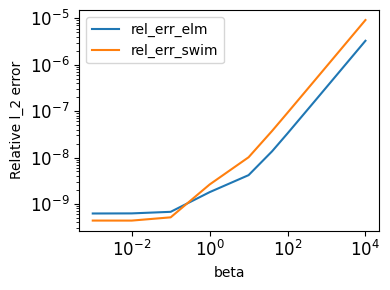

In [5]:
fontsize = 12

# Extract errors
conv_coeffs = np.reshape(np.asarray(conv_coeffs), (-1, 1))
rmse_elm = np.reshape(res[:, -4], (-1, 1))
rmse_swim = np.reshape(res[:, -2], (-1, 1))
rel_l2_elm = np.reshape(res[:, -8], (-1, 1))
rel_l2_swim = np.reshape(res[:, -6], (-1, 1))

# Store the errors for different values of beta
rmse = np.hstack((conv_coeffs, rmse_elm, rmse_swim))
rel_l2 = np.hstack((conv_coeffs, rel_l2_elm, rel_l2_swim))
print(np.shape(res))

# Store rel l2 error values for convergence plots
with open('adv_ode_swim_elm_rmse.npy', 'wb') as f:
    np.save(f, rmse)

with open('adv_ode_swim_elm_rel_l2.npy', 'wb') as f:
    np.save(f, rel_l2)

# Visualiza errors vs convection coefficient
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.loglog(conv_coeffs, res[:, -8], label='rel_err_elm')
ax.loglog(conv_coeffs, res[:, -6], label='rel_err_swim')
plt.xlabel('beta')
plt.ylabel('Relative l_2 error')
plt.tick_params(axis='both', labelsize=fontsize)
ax.legend()
fig.tight_layout()
plt.savefig('advection_ode_swim_elm.pdf', bbox_inches='tight')
